# APIs

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, LeaveOneOut, ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.datasets import load_iris, load_digits, make_blobs
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, f1_score, classification_report, precision_recall_curve, average_precision_score
from sklearn.ensemble import RandomForestClassifier

# UDFs

In [99]:
def plot_2d_separator(model, X, padding, h, ax=None, threshold=None):
    if ax is None:
        ax = plt.gca()
    
    x1_min, x1_max = X[:,0].min() - padding, X[:,0].max() + padding 
    x2_min, x2_max = X[:,1].min() - padding, X[:,1].max() + padding
    # print(x1_min, x1_max, x2_min, x2_max)

    xx, yy = np.meshgrid(
        np.linspace(x1_min, x1_max, h),
        np.linspace(x2_min, x2_max, h)
    )
    # print(xx.shape, yy.shape)

    grid = np.c_[xx.ravel(), yy.ravel()]
    # print(grid.shape)
    if threshold is None:
        Z_clf = model.predict(grid).reshape(xx.shape)
    else:
        Z_clf = model.decision_function(grid) > threshold
        Z_clf = Z_clf.reshape(xx.shape)

    ax.contour(xx, yy, Z_clf, alpha=0.8, colors='k')
    
    plt.xlim(x1_min, x1_max)
    plt.ylim(x2_min, x2_max) 

    return Z_clf

# Cross Validation

In [8]:
iris = load_iris()
logreg = LogisticRegression(max_iter=2000)

In [9]:
scores = cross_val_score(logreg, iris.data, iris.target)
print(f'Cross-validation scores: {scores}')

Cross-validation scores: [0.96666667 1.         0.93333333 0.96666667 1.        ]


In [10]:
print(f'Avg cross-validation score: {scores.mean():.2f}')

Avg cross-validation score: 0.97


## Stratified k-fold Cross Validation

In [11]:
kfold = KFold(n_splits=3)
print(f'Cross val scores w/o stratifying: {cross_val_score(logreg, iris.data, iris.target, cv=kfold)}')

Cross val scores w/o stratifying: [0. 0. 0.]


In [12]:
kfold = KFold(n_splits=3, shuffle=True, random_state=0)
print(f'Cross val scores w/ shuffling: {cross_val_score(logreg, iris.data, iris.target, cv=kfold)}')

Cross val scores w/ shuffling: [0.98 0.96 0.96]


In [13]:
strat_kfold = StratifiedKFold(n_splits=3)
print(f'Cross val scores w/ shuffling: {cross_val_score(logreg, iris.data, iris.target, cv=strat_kfold)}')

Cross val scores w/ shuffling: [0.98 0.96 0.98]


## Leave-one-out cross-validation

In [14]:
l1out = LeaveOneOut()
scores = cross_val_score(logreg, iris.data, iris.target, cv=l1out)
print(f'No of cv iterations: {len(scores)}')
print(f'Mean accuracy: {scores.mean():.3f}')

No of cv iterations: 150
Mean accuracy: 0.967


## Shuffle-split cross-validation

In [15]:
shuffle_split = ShuffleSplit(test_size=0.5, train_size=0.5, n_splits=10)
scores = cross_val_score(logreg, iris.data, iris.target, cv=shuffle_split)
print(f'Cross-val scores:\n{scores}')

Cross-val scores:
[0.96       0.96       0.94666667 0.94666667 0.98666667 1.
 0.94666667 0.94666667 0.98666667 1.        ]


# Grid Search

## With Cross-Validation

In [16]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

In [17]:
grid_search = GridSearchCV(SVC(), param_grid, cv=5)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)

In [20]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100]})

In [22]:
print(f'Test set score : {grid_search.score(X_test, y_test):.2f}')

Test set score : 0.97


In [24]:
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_:.2f}')

Best parameters: {'C': 10, 'gamma': 0.1}
Best score: 0.97


score method employs model trained on the whole training set.

The best_score_ attribute stores the mean CV accuracy, with CV performed on the training set

In [27]:
print(f'Best estimator: {grid_search.best_estimator_}')

Best estimator: SVC(C=10, gamma=0.1)


## Analyzing the result of CV

In [28]:
results = pd.DataFrame(grid_search.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.000782,0.000213,0.000538,0.000096,0.001,0.001,"{'C': 0.001, 'gamma': 0.001}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
1,0.001131,0.000170,0.001021,0.000325,0.001,0.010,"{'C': 0.001, 'gamma': 0.01}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
2,0.001055,0.000345,0.000622,0.000184,0.001,0.100,"{'C': 0.001, 'gamma': 0.1}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
3,0.000631,0.000013,0.000457,0.000010,0.001,1.000,"{'C': 0.001, 'gamma': 1}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
4,0.001134,0.000390,0.000703,0.000137,0.001,10.000,"{'C': 0.001, 'gamma': 10}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22


In [29]:
results.shape

(36, 15)

In [40]:
scores = np.array(results.mean_test_score).reshape(6, 6)

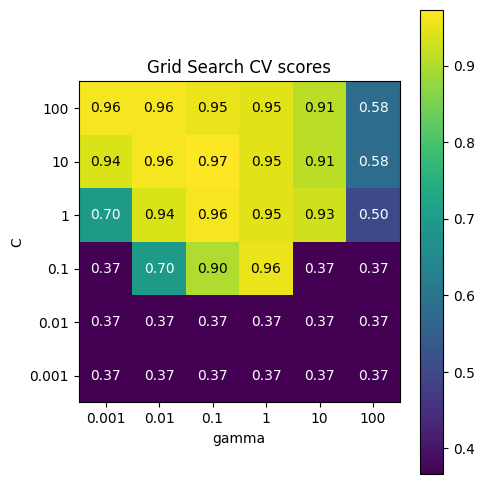

In [45]:
plt.figure(figsize=(5,5))
plt.imshow(scores, cmap='viridis', origin='lower')
plt.xlabel('gamma')
plt.xticks(range(len(param_grid['gamma'])), param_grid['gamma'])
plt.ylabel('C')
plt.yticks(range(len(param_grid['C'])), param_grid['C'])
plt.colorbar()
plt.title('Grid Search CV scores')
plt.tight_layout()

for i in range(scores.shape[0]):
    for j in range(scores.shape[1]):
        plt.text(j, i, f'{scores[i, j]:.2f}', ha='center', va='center', color='w' if scores[i, j] < 0.7 else 'k')

## param_grid

In [46]:
param_grid = [{'kernel': ['rbf'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100],
               'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
               {'kernel': ['linear'],
                'C': [0.001, 0.01, 0.1, 1, 10, 100]}]
print(f'List of grids:\n{param_grid}')

List of grids:
[{'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}, {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]


In [48]:
grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best CV score: {grid_search.best_score_:.2f}')

Best parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best CV score: 0.97


In [49]:
results = pd.DataFrame(grid_search.cv_results_)
results.T

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
mean_fit_time,0.00124,0.000922,0.000776,0.000629,0.000642,0.000678,0.00086,0.000688,0.000667,0.000698,...,0.000477,0.000553,0.000783,0.000885,0.000612,0.000589,0.000503,0.000533,0.000495,0.000496
std_fit_time,0.000661,0.000145,0.000148,0.000031,0.00002,0.000013,0.000158,0.000061,0.000011,0.000077,...,0.000015,0.000014,0.000045,0.000064,0.00001,0.00002,0.000009,0.000049,0.000014,0.000024
mean_score_time,0.000803,0.000576,0.000546,0.000441,0.000456,0.000474,0.000668,0.000492,0.000477,0.000502,...,0.000383,0.000395,0.000461,0.000567,0.000417,0.000422,0.00038,0.000477,0.000379,0.000373
std_score_time,0.000125,0.000097,0.000094,0.000016,0.000024,0.000014,0.000148,0.000039,0.000009,0.000048,...,0.000029,0.00001,0.000005,0.000107,0.000011,0.000014,0.00001,0.000181,0.000003,0.000012
param_C,0.001,0.001,0.001,0.001,0.001,0.001,0.01,0.01,0.01,0.01,...,100.0,100.0,100.0,100.0,0.001,0.01,0.1,1.0,10.0,100.0
param_gamma,0.001,0.01,0.1,1.0,10.0,100.0,0.001,0.01,0.1,1.0,...,0.1,1.0,10.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN
param_kernel,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,...,rbf,rbf,rbf,rbf,linear,linear,linear,linear,linear,linear
params,"{'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 10, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}",...,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 10, 'kernel': 'rbf'}","{'C': 100, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.001, 'kernel': 'linear'}","{'C': 0.01, 'kernel': 'linear'}","{'C': 0.1, 'kernel': 'linear'}","{'C': 1, 'kernel': 'linear'}","{'C': 10, 'kernel': 'linear'}","{'C': 100, 'kernel': 'linear'}"
split0_test_score,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,...,1.0,0.956522,0.869565,0.521739,0.347826,0.869565,1.0,1.0,1.0,0.956522
split1_test_score,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,...,0.956522,0.956522,0.913043,0.521739,0.347826,0.869565,0.913043,0.956522,1.0,0.956522


## Nested CV

In [50]:
scores = cross_val_score(GridSearchCV(SVC(), param_grid, cv=5),
                         iris.data, iris.target, cv=5)
print(f'CV scores: {scores}')
print(f'Mean CV score: {scores.mean():.2f}')

CV scores: [0.96666667 1.         0.9        0.96666667 1.        ]
Mean CV score: 0.97


# Imbalanced Data

In [52]:
digits = load_digits()

creating a 9:1 imbalanced dataset by classifying the digit 9 against the 9 other classes

In [53]:
y = digits.target == 9

In [55]:
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=0)

dummy classifier

In [57]:
dummy_majority = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
pred_most_freq = dummy_majority.predict(X_test)
print(f'Unique predicted labels: {np.unique(pred_most_freq)}')
print(f'Test score: {dummy_majority.score(X_test, y_test):.2f}')

Unique predicted labels: [False]
Test score: 0.90


Actual Classifier

In [59]:
tree = DecisionTreeClassifier(max_depth=2).fit(X_train, y_train)
pred_tree = tree.predict(X_test)
print(f'Test score: {tree.score(X_test, y_test):.2f}')

Test score: 0.92


# Confusion Matrices

In [62]:
logreg = LogisticRegression(C=0.1, max_iter=2000).fit(X_train, y_train)
print(f'Test score: {logreg.score(X_test, y_test):.2f}')

Test score: 0.98


In [63]:
pred_logreg = logreg.predict(X_test)
confusion = confusion_matrix(y_test, pred_logreg)
print(f'Confusion matrix:\n{confusion}')

Confusion matrix:
[[402   1]
 [  6  41]]


Evaluating using f1_score

In [65]:
print(f'f1 score for most frequent model: {f1_score(y_test, pred_most_freq):.2f}')
print(f'f1 score for DT: {f1_score(y_test, pred_tree):.2f}')
print(f'f1 score for Logistic Reg: {f1_score(y_test, pred_logreg):.2f}')

f1 score for most frequent model: 0.00
f1 score for DT: 0.55
f1 score for Logistic Reg: 0.92


In [67]:
print(classification_report(y_test, pred_logreg, target_names=['not nine', 'nine']))

              precision    recall  f1-score   support

    not nine       0.99      1.00      0.99       403
        nine       0.98      0.87      0.92        47

    accuracy                           0.98       450
   macro avg       0.98      0.93      0.96       450
weighted avg       0.98      0.98      0.98       450



# Setting thresholds to predict class

In [ ]:
X, y = make_blobs(n_samples=(400, 50), cluster_std=[7, 2], random_state=22)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
svc = SVC(gamma=0.05).fit(X_train, y_train)

Text(0.5, 1.0, 'decision with threshold -0.8')

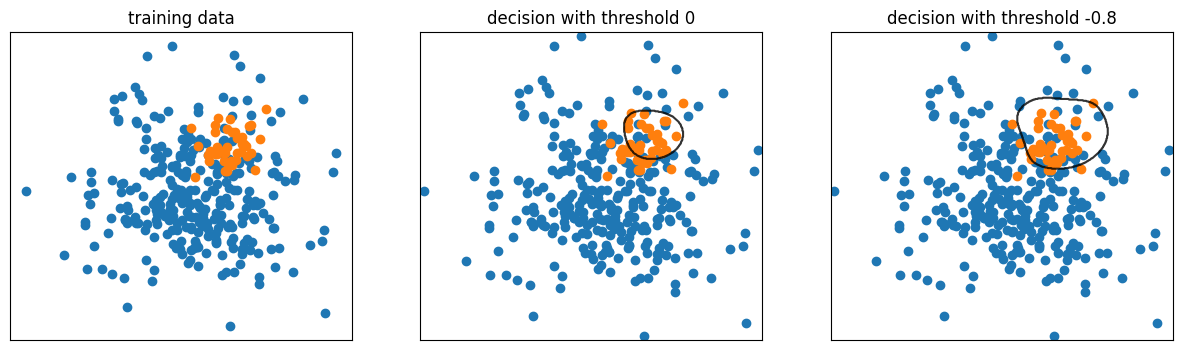

In [105]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), subplot_kw={'xticks':(), 'yticks':()})

for label in np.unique(y_train):
    axes[0].scatter(X_train[y_train==label, 0], X_train[y_train==label, 1], label=f'Class {label}')
axes[0].set_title('training data')

for label in np.unique(y_train):
    axes[1].scatter(X_train[y_train==label, 0], X_train[y_train==label, 1], label=f'Class {label}')
plot_2d_separator(svc, X_train, 0.5, 500,ax=axes[1], threshold=0)
axes[1].set_title('decision with threshold 0')

for label in np.unique(y_train):
    axes[2].scatter(X_train[y_train==label, 0], X_train[y_train==label, 1], label=f'Class {label}')
plot_2d_separator(svc, X_train, 0.5, 500,ax=axes[2], threshold=-0.8)
axes[2].set_title('decision with threshold -0.8')

# Precision-Recall Curve

## for SVC

In [107]:
precision, recall, thresholds = precision_recall_curve(y_test, svc.decision_function(X_test))

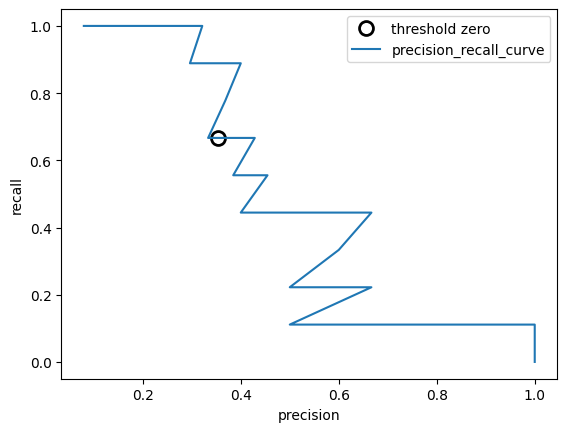

In [116]:
close_zero = np.argmin(np.abs(thresholds))
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10, label='threshold zero',
         fillstyle='none', c='k', mew=2)

plt.plot(precision, recall, label='precision_recall_curve')
plt.xlabel('precision')
plt.ylabel('recall')
plt.legend()

## for Random Forest

In [120]:
X, y = make_blobs(n_samples=(4000, 500), cluster_std=[7, 2], random_state=22)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
svc = SVC(gamma=0.05).fit(X_train, y_train)

In [121]:
rf = RandomForestClassifier(n_estimators=100, random_state=0, max_features=2)
rf.fit(X_train, y_train)

RandomForestClassifier(max_features=2, random_state=0)

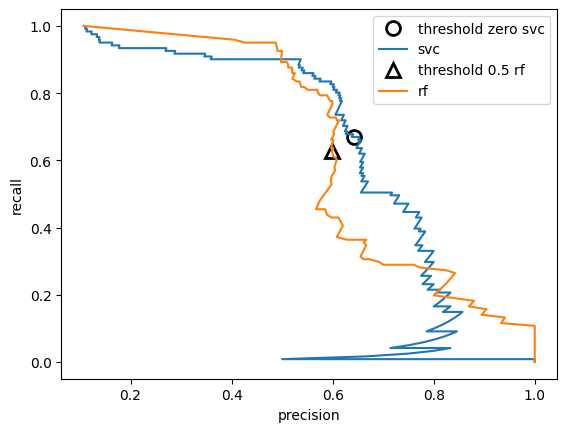

In [124]:
# svc
precision, recall, thresholds = precision_recall_curve(y_test, svc.decision_function(X_test))
close_zero = np.argmin(np.abs(thresholds))
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10, label='threshold zero svc',
         fillstyle='none', c='k', mew=2)
plt.plot(precision, recall, label='svc')

# rf
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, rf.predict_proba(X_test)[:, 1])
close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot(precision_rf[close_default_rf], recall_rf[close_default_rf], '^', markersize=10, label='threshold 0.5 rf',
         fillstyle='none', c='k', mew=2)
plt.plot(precision_rf, recall_rf, label='rf')

plt.xlabel('precision')
plt.ylabel('recall')
plt.legend()

In [127]:
print(f'f1_score of rf  : {f1_score(y_test, rf.predict(X_test)):.3f}')
print(f'f1_score of svc : {f1_score(y_test, svc.predict(X_test)):.3f}')

f1_score of rf  : 0.610
f1_score of svc : 0.656


In [131]:
ap_rf = average_precision_score(y_test, rf.predict_proba(X_test)[:, 1])
ap_svc = average_precision_score(y_test, svc.decision_function(X_test))
print(f'Avg precision of RF  : {ap_rf:.3f}')
print(f'Avg precision of SVC : {ap_svc:.3f}')

Avg precision of RF  : 0.660
Avg precision of SVC : 0.666
